# 生成数据集

In [26]:
import sqlite3
import pandas as pd
import json

# 连接 SQLite 数据库
db_path = "latest.db"  # 替换为实际路径
conn = sqlite3.connect(db_path)

# 1. 筛选 BIOG_MAIN 中满足条件的 c_personid
query_biog_main = """
SELECT c_personid
FROM BIOG_MAIN
WHERE c_dy = 20 AND c_ethnicity_code = 1
"""
biog_main = pd.read_sql(query_biog_main, conn)

# 2. 获取 ENTRY_DATA 中 c_personid 对应的 c_entry_code
query_entry_data = """
SELECT c_personid, c_entry_code
FROM ENTRY_DATA
"""
entry_data = pd.read_sql(query_entry_data, conn)

# 聚合 ENTRY_DATA 中同一 c_personid 的 c_entry_code
entry_data_agg = entry_data.groupby('c_personid')['c_entry_code'].agg(list).reset_index()

# 合并入仕信息
print(f"BIOG_MAIN 条数（原始）：{len(biog_main)}")
biog_main = biog_main.merge(entry_data_agg, on='c_personid', how='left')
print(f"BIOG_MAIN 条数（合并 ENTRY_DATA 后）：{len(biog_main)}")

# 填充缺失的 c_entry_code 为 -2，并转为整数类型
biog_main['c_entry_code'] = biog_main['c_entry_code'].apply(lambda x: x if isinstance(x, list) else [-2])

# 3. 获取 KIN_DATA 中 c_personid 对应的 c_kin_id 和 c_kin_code
query_kin_data = """
SELECT c_personid, c_kin_id, c_kin_code
FROM KIN_DATA
"""
kin_data = pd.read_sql(query_kin_data, conn)

# 合并家庭信息（保持多对一关系）
kin_data['c_kin_id'] = kin_data['c_kin_id'].fillna(-2).astype(int)
kin_data['c_kin_code'] = kin_data['c_kin_code'].fillna(-2).astype(int)

# 4. 获取 KINSHIP_CODES 中 c_kin_code 对应的 c_kin_pair1 和 c_kin_pair2
query_kinship_codes = """
SELECT c_kincode, c_kin_pair1, c_kin_pair2
FROM KINSHIP_CODES
"""
kinship_codes = pd.read_sql(query_kinship_codes, conn)

# 合并亲属关系信息
kinship_codes['c_kin_pair1'] = kinship_codes['c_kin_pair1'].fillna(-2).astype(int)
kinship_codes['c_kin_pair2'] = kinship_codes['c_kin_pair2'].fillna(-2).astype(int)

# 关闭数据库连接
conn.close()

# 5. 整合信息到 JSON 格式
result = []
for _, row in biog_main.iterrows():
    person_data = {
        "c_personid": int(row['c_personid']),
        "c_entry_code": row['c_entry_code'],  # 保持 c_entry_code 为列表形式
        "kinships": []
    }

    # 获取当前 c_personid 的家庭信息
    person_kin_data = kin_data[kin_data['c_personid'] == row['c_personid']]
    for _, kin_row in person_kin_data.iterrows():
        kin_code = int(kin_row['c_kin_code'])
        kin_info = {
            "c_kin_id": int(kin_row['c_kin_id']),
            "c_kin_code": kin_code,
            "c_kin_pair1": -2,
            "c_kin_pair2": -2
        }

        # 获取 c_kin_code 对应的亲属关系
        kinship_info = kinship_codes[kinship_codes['c_kincode'] == kin_code]
        if not kinship_info.empty:
            kin_info['c_kin_pair1'] = int(kinship_info.iloc[0]['c_kin_pair1'])
            kin_info['c_kin_pair2'] = int(kinship_info.iloc[0]['c_kin_pair2'])

        person_data["kinships"].append(kin_info)

    result.append(person_data)
# 6. 写入 JSON 文件
with open("conservative_all_data.json", "w", encoding="utf-8") as f:
    json.dump(result, f, ensure_ascii=False, indent=4)

print("JSON 文件生成成功：advanced_filtered_data.json")


BIOG_MAIN 条数（原始）：23726
BIOG_MAIN 条数（合并 ENTRY_DATA 后）：23726
JSON 文件生成成功：advanced_filtered_data.json


# 加载文件形成图结构

In [1]:
import json
import dgl
import torch

# 加载 JSON 文件
with open("advanced_filtered_data.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# 统计 kinships 为空的节点数量
total_nodes = len(data)
data_with_kinships = [person for person in data if len(person.get("kinships", [])) > 0]
nodes_without_kinships = total_nodes - len(data_with_kinships)
proportion_without_kinships = nodes_without_kinships / total_nodes

print(f"Total nodes: {total_nodes}")
print(f"Nodes without kinships: {nodes_without_kinships}")
print(f"Proportion of nodes without kinships: {proportion_without_kinships:.2%}")

# 跳过 kinships 为空的观测
data = data_with_kinships

# 构建 node_id_map，确保所有 c_personid 和 c_kin_id 都被映射
node_ids = []         # 所有的 c_personid
kin_ids = set()      # 所有的 c_kin_id（去重）
node_labels = []     # 节点标签
entry_code_features = []   # 存储 c_entry_code 特征
kinship_count_features = []  # 存储 kinships 数量特征

# 遍历 JSON 数据，构建节点和边
for person in data:
    # 添加节点 ID
    node_ids.append(person["c_personid"])

    # 处理入仕标签：检查 c_entry_code 列表中是否有非负值
    c_entry_code = person["c_entry_code"]
    if any(code >= 0 for code in c_entry_code):  # 只要有一个非负值，就视为入仕
        node_labels.append(1)  # 入仕，标签为 1
    else:
        node_labels.append(0)  # 未入仕，标签为 0

    # 提取 c_entry_code 特征：如果有值，则选择第一个有效的（或者填充为 -2）
    entry_code_feature = c_entry_code[0] if c_entry_code else -2
    entry_code_features.append([entry_code_feature])

    # 计算 kinships 数量
    kinship_count_features.append([len(person.get("kinships", []))])

    # 添加 kin_ids
    for kinship in person.get("kinships", []):
        kin_ids.add(kinship["c_kin_id"])

# 构建 node_id_map，确保所有的 c_personid 和 c_kin_id 都在映射中
node_id_map = {nid: idx for idx, nid in enumerate(node_ids)}
kin_id_map = {kin_id: idx + len(node_id_map) for idx, kin_id in enumerate(kin_ids)}  # 确保 kin_id 从 node_id_map 后面开始

# 合并 node_id_map 和 kin_id_map
node_id_map.update(kin_id_map)

# 创建图
edges_src = []        # 边的起点
edges_dst = []        # 边的终点

# 遍历数据构建边，并模拟无向图（双向边）
for person in data:
    for kinship in person.get("kinships", []):
        src_node = person["c_personid"]
        dst_node = kinship["c_kin_id"]

        # 仅添加有效的边
        if src_node in node_id_map and dst_node in node_id_map:
            edges_src.append(node_id_map[src_node])
            edges_dst.append(node_id_map[dst_node])

            # 添加反向边，模拟无向图
            edges_src.append(node_id_map[dst_node])
            edges_dst.append(node_id_map[src_node])

# 确保 `edges_src` 和 `edges_dst` 的长度一致
assert len(edges_src) == len(edges_dst), "Source and destination nodes' lengths do not match"

# 构建图
g = dgl.graph((edges_src, edges_dst))

# 填充缺失的节点标签和特征，直到它们的数量与图的节点数一致
while len(node_labels) < g.num_nodes():
    node_labels.append(0)  # 填充为默认标签 0（未入仕）

while len(entry_code_features) < g.num_nodes():
    entry_code_features.append([-2])  # 填充为默认特征值 [-2]（无入仕信息）

while len(kinship_count_features) < g.num_nodes():
    kinship_count_features.append([0])  # 填充为默认特征值 0（无家庭关系）

# 设置节点标签和特征
g.ndata['label'] = torch.tensor(node_labels)  # 填充后的标签
g.ndata['entry_code_feat'] = torch.tensor(entry_code_features, dtype=torch.float)  # c_entry_code 特征
g.ndata['kinship_count_feat'] = torch.tensor(kinship_count_features, dtype=torch.float)  # kinships 数量特征

# 输出图的基本信息
print("图的节点数：", g.num_nodes())
print("图的边数：", g.num_edges())
print("c_entry_code 特征：", g.ndata['entry_code_feat'].shape)
print("kinships 数量特征：", g.ndata['kinship_count_feat'].shape)
print("节点标签：", g.ndata['label'].shape)


Total nodes: 23726
Nodes without kinships: 22688
Proportion of nodes without kinships: 95.63%
图的节点数： 3026
图的边数： 6034
c_entry_code 特征： torch.Size([3026, 1])
kinships 数量特征： torch.Size([3026, 1])
节点标签： torch.Size([3026])


# 对图的一些统计

In [29]:
# 构图完成后重新统计入仕者比例
entry_code_feat = g.ndata['entry_code_feat'].numpy()
total_nodes_in_graph = g.num_nodes()
positive_nodes_in_graph = sum(1 for feat in entry_code_feat if feat[0] >= 0)
positive_ratio_in_graph = positive_nodes_in_graph / total_nodes_in_graph

print(f"Total nodes in graph: {total_nodes_in_graph}")
print(f"Positive nodes (入仕者数量): {positive_nodes_in_graph}")
print(f"入仕者比例: {positive_ratio_in_graph:.2%}")


Total nodes in graph: 3026
Positive nodes (入仕者数量): 212
入仕者比例: 7.01%


In [30]:
# 先打印一些边信息
print(f"First 5 edges: {list(zip(edges_src, edges_dst))[:5]}")
print(f"Total number of edges: {len(edges_src)}")

# 查看节点入度信息
for node in range(g.num_nodes()):
    print(f"Node {node} in-degree: {g.in_degrees(node)}")


First 5 edges: [(1905, 1891), (1905, 1892), (1905, 2795), (1835, 1846), (1835, 1861)]
Total number of edges: 3017
Node 0 in-degree: 0
Node 1 in-degree: 0
Node 2 in-degree: 0
Node 3 in-degree: 0
Node 4 in-degree: 0
Node 5 in-degree: 0
Node 6 in-degree: 0
Node 7 in-degree: 0
Node 8 in-degree: 0
Node 9 in-degree: 0
Node 10 in-degree: 0
Node 11 in-degree: 0
Node 12 in-degree: 0
Node 13 in-degree: 0
Node 14 in-degree: 0
Node 15 in-degree: 0
Node 16 in-degree: 0
Node 17 in-degree: 0
Node 18 in-degree: 0
Node 19 in-degree: 0
Node 20 in-degree: 0
Node 21 in-degree: 0
Node 22 in-degree: 0
Node 23 in-degree: 0
Node 24 in-degree: 0
Node 25 in-degree: 0
Node 26 in-degree: 0
Node 27 in-degree: 0
Node 28 in-degree: 0
Node 29 in-degree: 0
Node 30 in-degree: 0
Node 31 in-degree: 0
Node 32 in-degree: 0
Node 33 in-degree: 0
Node 34 in-degree: 0
Node 35 in-degree: 0
Node 36 in-degree: 0
Node 37 in-degree: 0
Node 38 in-degree: 0
Node 39 in-degree: 0
Node 40 in-degree: 0
Node 41 in-degree: 0
Node 42 in-deg

# 建模

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import dgl
import dgl.nn as dglnn

# 定义 GCN 模型
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_feats, out_feats):
        super(GCN, self).__init__()
        # 图卷积层（减少了卷积层的数量）
        self.conv1 = dglnn.GraphConv(in_feats, hidden_feats, allow_zero_in_degree=True)
        self.conv2 = dglnn.GraphConv(hidden_feats, out_feats, allow_zero_in_degree=True)

    def forward(self, g, features):
        # 第一层图卷积
        h = self.conv1(g, features)
        h = F.relu(h)
        # 第二层图卷积
        h = self.conv2(g, h)
        return h

# 参数设置
in_feats = 2  # 输入特征维度（c_entry_code 和 kinships 数量）
hidden_feats = 8  # 减小隐藏层特征维度
out_feats = 2  # 输出类别数（这里是2，假设是二分类任务）

# 实例化模型
model = GCN(in_feats, hidden_feats, out_feats)

# 选择优化器
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)  # 使用较低的学习率

# 准备数据
features = torch.cat((g.ndata['entry_code_feat'], g.ndata['kinship_count_feat']), dim=1)  # 合并两个特征
labels = g.ndata['label']  # 节点标签

# 将数据集划分为训练集和测试集
train_mask = torch.randint(0, 2, (g.num_nodes(),)).bool()  # 随机划分训练数据
train_labels = labels[train_mask]  # 训练标签
train_features = features[train_mask]  # 训练特征

# 训练模型
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # 前向传播
    logits = model(g, features)
    
    # 计算损失（这里使用交叉熵损失）
    loss = F.cross_entropy(logits[train_mask], train_labels)
    loss.backward()
    optimizer.step()

    # 输出每轮的损失
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

# 模型评估
model.eval()
with torch.no_grad():
    logits = model(g, features)
    pred = logits.argmax(dim=1)  # 预测标签
    print("Prediction:", pred)

# 输出模型的基本信息
print("Number of nodes in the graph:", g.num_nodes())
print("Number of edges in the graph:", g.num_edges())


Epoch 0, Loss: 1.6581346988677979
Epoch 10, Loss: 1.071252465248108
Epoch 20, Loss: 0.779522180557251
Epoch 30, Loss: 0.5886121988296509
Epoch 40, Loss: 0.45600149035453796
Epoch 50, Loss: 0.3630695939064026
Epoch 60, Loss: 0.2983328700065613
Epoch 70, Loss: 0.2534205913543701
Epoch 80, Loss: 0.22209839522838593
Epoch 90, Loss: 0.19991576671600342
Prediction: tensor([0, 0, 0,  ..., 0, 0, 0])
Number of nodes in the graph: 3026
Number of edges in the graph: 6034


# 验证结果

Test Accuracy: 96.53%
Precision: 0.9652
Recall: 0.5236
F1 Score: 0.6789
Confusion Matrix:
[[2810    4]
 [ 101  111]]


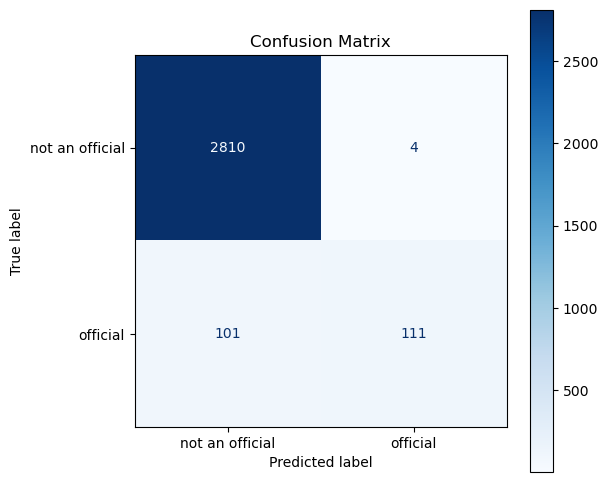

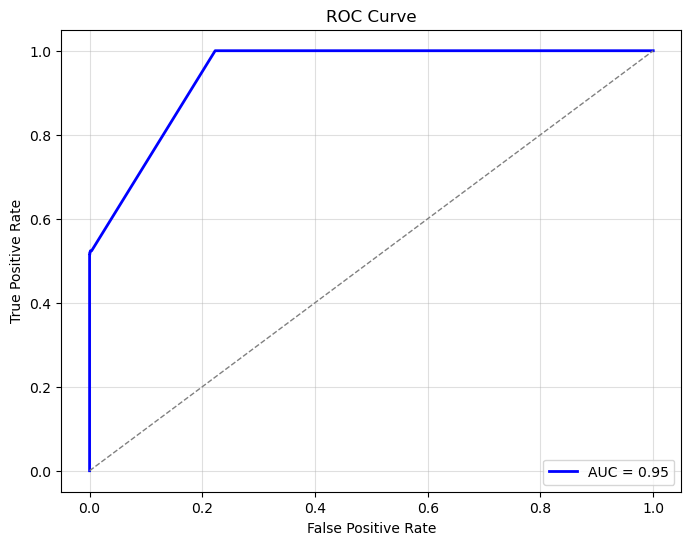

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

# 设置模型为评估模式
model.eval()
with torch.no_grad():
    logits = model(g, features)  # 模型输出
    pred = logits.argmax(dim=1)  # 预测标签

    # 计算各项指标
    accuracy = accuracy_score(labels.numpy(), pred.numpy())
    precision = precision_score(labels.numpy(), pred.numpy(), average='binary')
    recall = recall_score(labels.numpy(), pred.numpy(), average='binary')
    f1 = f1_score(labels.numpy(), pred.numpy(), average='binary')
    conf_matrix = confusion_matrix(labels.numpy(), pred.numpy())

    # 获取 ROC 曲线和 AUC
    probs = logits[:, 1].numpy()  # 获取属于类别 1（入仕）的概率
    fpr, tpr, thresholds = roc_curve(labels.numpy(), probs)
    roc_auc = auc(fpr, tpr)

# 打印评估指标
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

# 可视化混淆矩阵
plt.figure(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["not an official", "official"])
disp.plot(cmap=plt.cm.Blues, values_format="d", ax=plt.gca())
plt.title("Confusion Matrix")
plt.show()

# 绘制 ROC 曲线
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # 随机分类参考线
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(alpha=0.4)
plt.show()
